Here we will test our single view models and our multiview model using the generated data.

In [5]:
import os
import keras
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from transformers import AutoTokenizer, TFAutoModel
import tensorflow_datasets as tfds
from keras.datasets import mnist 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, accuracy_score

from PIL import Image
from keras.callbacks import EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.models import Model

%load_ext autoreload
%autoreload 2

from utils import show_performance_metrics, preprocess_image, augment_image, apply_augmentation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# --- Configuration ---
# Image dimensions for ResNet50 input
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3 # ResNet50 expects 3 channels (RGB)

# Batch size for training
BATCH_SIZE = 16 

# Number of epochs for training the classifier head
EPOCHS = 30

# Learning rate for the classifier head
LEARNING_RATE = 1e-4

# Seed used for splitting the train, validation and test dataset 
seed = 11

In [7]:
# ---  Data Loading from CSV ---
try:
    df = pd.read_csv('../handwriting_generation/dyslexia_handwriting_dataset.csv')
    print("--- Successfully loaded dyslexia_handwriting_dataset.csv ---")
except FileNotFoundError:
    print("Error: 'dyslexia_handwriting_dataset.csv' not found. Please ensure the CSV file is in the same directory as the script.")
    exit()

if 'file_path' not in df.columns or 'text' not in df.columns or 'presence_of_dyslexia' not in df.columns:
    print("Error: CSV must contain 'file_path', 'text', and 'presence_of_dyslexia' columns.")
    exit()

# Convert labels to integer type
df['presence_of_dyslexia'] = df['presence_of_dyslexia'].astype(int)

print("--- DataFrame Head ---")
print(df.head())
print("\n--- Value Counts for Dyslexia Presence ---")
print(df['presence_of_dyslexia'].value_counts())

--- Successfully loaded dyslexia_handwriting_dataset.csv ---
--- DataFrame Head ---
   presence_of_dyslexia                                          file_path  \
0                     0  ../data/normal_handwriting_images/normal_sampl...   
1                     0  ../data/normal_handwriting_images/normal_sampl...   
2                     0  ../data/normal_handwriting_images/normal_sampl...   
3                     0  ../data/normal_handwriting_images/normal_sampl...   
4                     0  ../data/normal_handwriting_images/normal_sampl...   

                                                text  
0  My best friend, Violet, has a navy pet hedgeho...  
1  My best friend, Kevin, has a silver pet parrot...  
2  My best friend, George, has a navy pet fish. G...  
3  My best friend, Mia, has a gold pet budgie. Mi...  
4  My best friend, Laura, has a yellow pet hamste...  

--- Value Counts for Dyslexia Presence ---
presence_of_dyslexia
0    500
1    500
Name: count, dtype: int64


# 1  Single View model Using Images


Total files: 1000
Training files: 700 (70.0%)
Validation files: 150 (15.0%)
Test files: 150 (15.0%)

--- tf.data.Dataset created successfully ---

--- Model Summary (Initial Frozen Layers) ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Training the model for 30 epochs ---
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.8374 - loss: 0.3457 - val_accuracy: 0.9733 - val_loss: 0.0769
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.9736 - loss: 0.0610 - val_accuracy: 0.9800 - val_loss: 0.0578
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.9854 - loss: 0.0435 - val_accuracy: 0.9867 - val_loss: 0.0445
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.9923 - loss: 0.0250 - val_accuracy: 0.9867 - val_loss: 0.0794
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.9934 - loss: 0.0210 - val_accuracy: 0.9867 - val_loss: 0.0503
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.9811 - loss: 0.0541 - val_accuracy: 0.9733 - val_loss: 0.0600
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.9868 - loss: 0.0513 - val_accuracy: 0.9933 - val_loss: 0.0389
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accurac

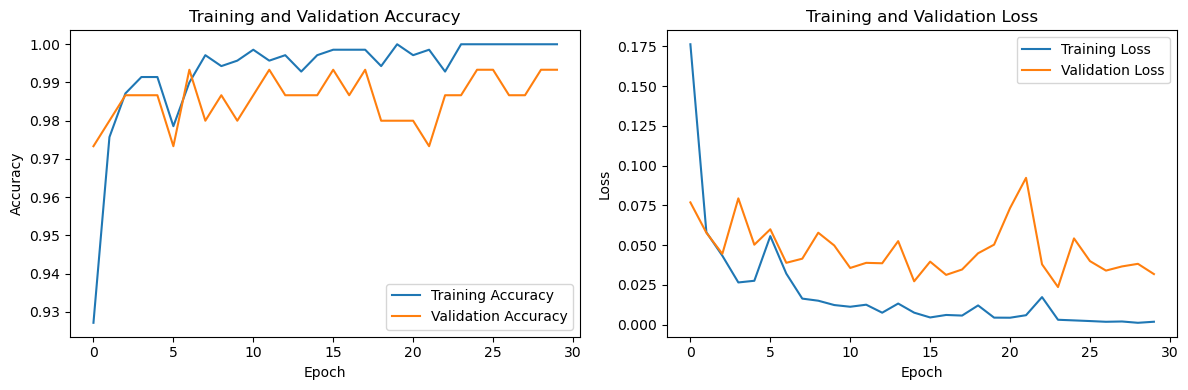


Confusion Matrix:


2025-08-22 16:43:17.858104: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


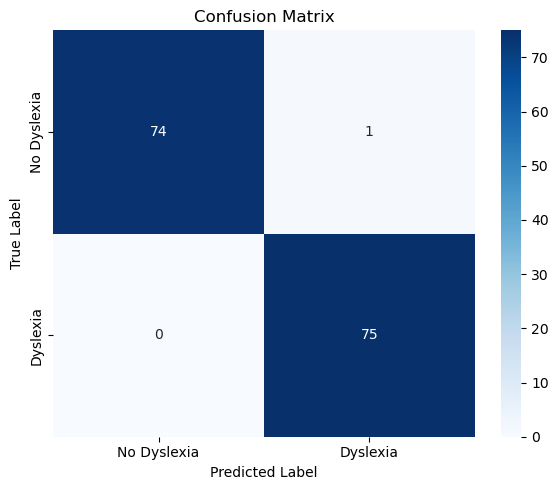


Additional Metrics for Test Results:
Sensitivity (Recall): 1.0000
Specificity: 0.9867
F1 Score: 0.9934

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       1.00      0.99      0.99        75
    Dyslexia       0.99      1.00      0.99        75

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

ROC AUC Score (Prob-based): 1.0000
PR AUC Score: 1.0000


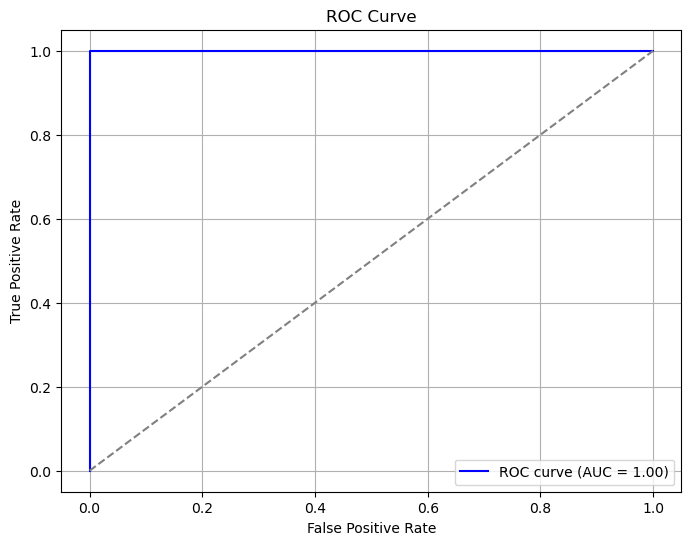

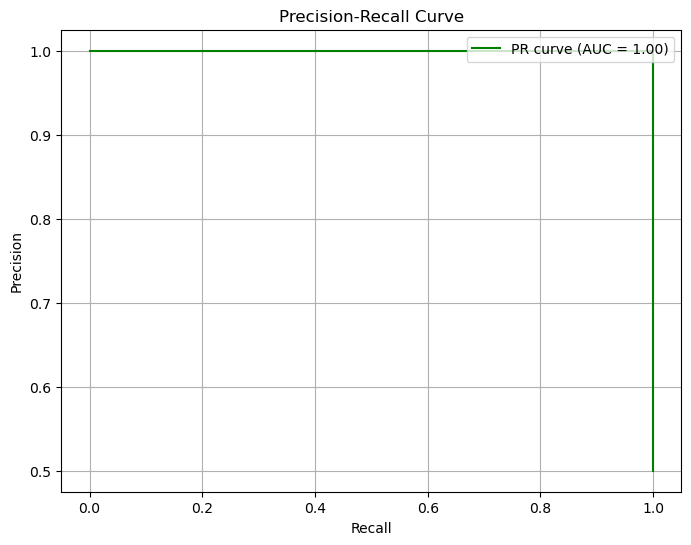

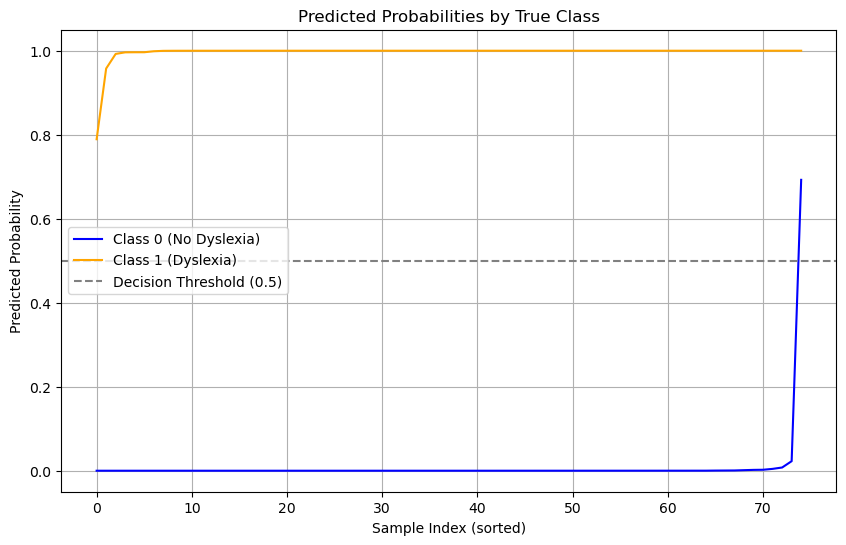

In [ ]:
# Create Single View model using handwriting images 

# ---  Data Splitting ---
# 70% Training, 15% Validation, 15% Testing

# Split into training and (validation + test)
train_df, val_test_df = train_test_split(
    df,
    test_size=0.3, 
    stratify=df['presence_of_dyslexia'], # Maintain class distribution
    random_state=seed
)

# Then, split (validation + test) into validation and test
val_df, test_df = train_test_split(
    val_test_df,
    test_size=0.5, 
    stratify=val_test_df['presence_of_dyslexia'], # Maintain class distribution
    random_state=seed
)

print(f"\nTotal files: {len(df)}")
print(f"Training files: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation files: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test files: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# --- Image Preprocessing and tf.data.Dataset creation ---

# Create tf.data.Dataset from DataFrames
def create_dataset(dataframe, augment=False, shuffle=False):
    # Convert file_path and presence_of_dyslexia columns to TensorFlow tensors
    file_paths = tf.constant(dataframe['file_path'].tolist())
    labels = tf.constant(dataframe['presence_of_dyslexia'].tolist(), dtype=tf.float32) # Ensure labels are float for binary classification

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), seed=seed)

    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE) # Prefetch for performance
    return dataset

train_dataset = create_dataset(train_df, augment=True, shuffle=True)
validation_dataset = create_dataset(val_df, augment=False, shuffle=False)
test_dataset = create_dataset(test_df, augment=False, shuffle=False)

print("\n--- tf.data.Dataset created successfully ---")
# for images, labels in train_dataset.take(1):
#     print(f"Shape of a batch of images: {images.shape}")
#     print(f"Shape of a batch of labels: {labels.shape}")

# ---  Model Building (ResNet50 for Binary Classification) ---
# Load ResNet50 model with pre-trained ImageNet weights, excluding the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers to prevent their weights from being updated during initial training.
# This uses the pre-learned features from ImageNet as-is.
base_model.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces spatial dimensions to 1x1, capturing global features
x = Dense(256, activation='relu')(x) # A dense layer before the final output
predictions = Dense(1, activation='sigmoid')(x) # Output layer for binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
# Using Adam optimizer, binary_crossentropy for binary classification, and accuracy as metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("\n--- Model Summary (Initial Frozen Layers) ---")
model.summary()

# ---  Model Training ---
# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
print(f"\n--- Training the model for {EPOCHS} epochs ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=[early_stopping_callback]
)

# Future work: Fine-tuning (unfreeze some layers and train again with a lower learning rate)
# Can do for small datasets to adapt the pre-trained features.
'''print("\n--- Fine-tuning: Unfreezing top layers of ResNet50 ---")
base_model.trainable = True # Unfreeze the base model

# Start by unfreezing a small number of layers from the top of the base model
# and keep the lower layers (earlier layers) frozen, as they learn more generic features.
# Can experiment with different numbers of layers to unfreeze.
# The `len(base_model.layers) - 50` means unfreezing the last 50 layers.
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Lower learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\n--- Model Summary (After Unfreezing) ---")
model.summary()

# Continue training for a few more epochs
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print(f"\n--- Fine-tuning the model for {fine_tune_epochs} more epochs ---")
history_fine_tune = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Start from where previous training left off
    validation_data=validation_dataset,
    callbacks=[early_stopping_callback]
)'''

# ---  Model Evaluation ---
print("\n--- Evaluating the model on the test set ---")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# --- Save the model ---
# model_save_path = 'dyslexia_detection_resnet50.h5'
# model.save(model_save_path)
# print(f"\nModel saved to {model_save_path}")

# ---  Visualize Training History ---
# Combine history from initial training and fine-tuning
acc = history.history['accuracy'] #+ history_fine_tune.history['accuracy']
val_acc = history.history['val_accuracy'] #+ history_fine_tune.history['val_accuracy']
loss = history.history['loss'] #+ history_fine_tune.history['loss']
val_loss = history.history['val_loss'] #+ history_fine_tune.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
# --- Gather predictions and true labels ---
all_probs = []
all_labels = []

for images, labels in test_dataset:
    probs = model.predict(images, verbose=0).flatten()
    all_probs.extend(probs)
    all_labels.extend(labels.numpy())

# --- Show final performance metrics ---
show_performance_metrics(all_labels, all_probs)


# 2  Single View model using transcript text 

Loading BERT tokenizer and tokenizing all text...


/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


All text tokenized. Input IDs shape: (1000, 128), Attention Masks shape: (1000, 128)
Training samples: 700
Validation samples: 150
TensorFlow Datasets created from preprocessed NumPy arrays for text.
Building single-view text model architecture...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

BERT model wrapped in custom layer and layers frozen.
Compiling text model...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_feature_extra… │ (None, 768)       │          0 │ attention_mask[0… │
│ (BertEmbeddingLaye… │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    196,864 │ bert_feature_ext… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        257 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 197,121 (770.00 KB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 0 (0.00 B)

Training text model...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 510ms/step - accuracy: 0.5924 - loss: 0.6847 - val_accuracy: 0.9733 - val_loss: 0.2670
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 492ms/step - accuracy: 0.9398 - loss: 0.2802 - val_accuracy: 0.9733 - val_loss: 0.1592
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9436 - loss: 0.2064 - val_accuracy: 0.9733 - val_loss: 0.1253
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 490ms/step - accuracy: 0.9528 - loss: 0.1729 - val_accuracy: 0.9733 - val_loss: 0.1108
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9573 - loss: 0.1654 - val_accuracy: 0.9733 - val_loss: 0.1009
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 490ms/step - accuracy: 0.9527 - loss: 0.1497 - val_accuracy: 0.9733 - val_loss: 0.0950
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9652 - loss: 0.1415 - val_accuracy: 0.9733 - val_loss: 0.0898
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 490ms/step - accuracy: 0.9616 - 

2025-08-22 16:54:18.834800: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


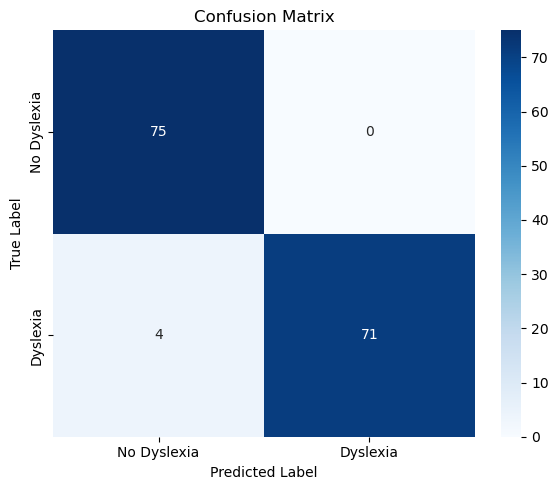


Additional Metrics for Test Results:
Sensitivity (Recall): 0.9467
Specificity: 1.0000
F1 Score: 0.9726

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       0.95      1.00      0.97        75
    Dyslexia       1.00      0.95      0.97        75

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

ROC AUC Score (Prob-based): 0.9675
PR AUC Score: 0.9820


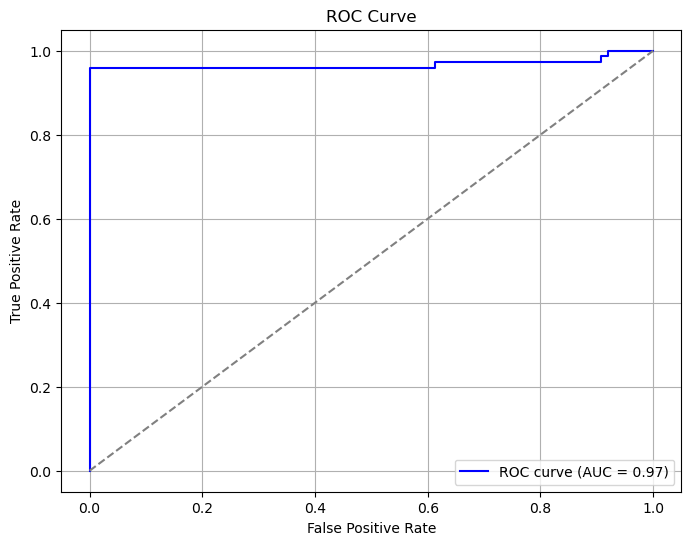

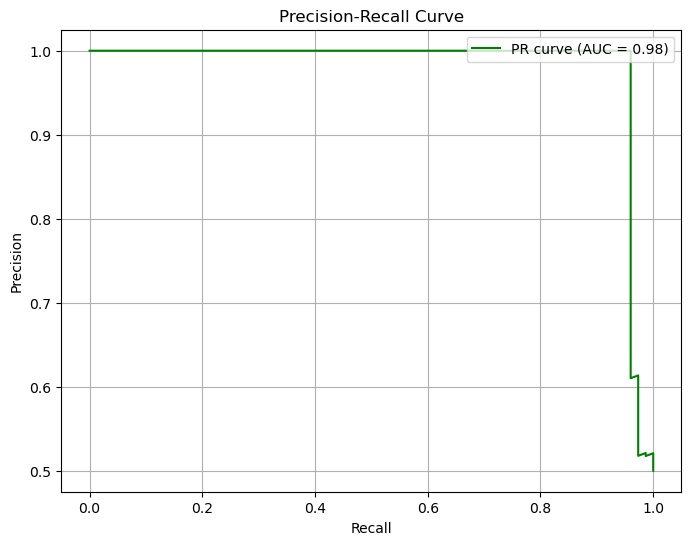

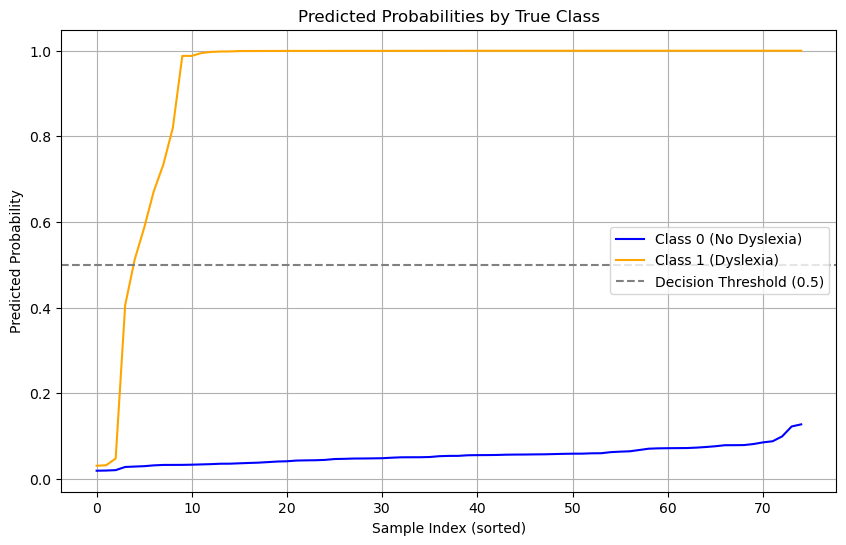


Text single-view model training and evaluation complete.


In [12]:
# Create Single View model using transcript text 
# --- Text Tokenization (Pre-tokenizing all text) ---
print("Loading BERT tokenizer and tokenizing all text...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") 

all_input_ids = []
all_attention_masks = []

for text_entry in df['text']:
    encoded_input = tokenizer(
        text_entry,
        padding='max_length',
        truncation=True,
        max_length=128, # Consistent max length
        return_tensors='np' 
    )
    all_input_ids.append(encoded_input['input_ids'][0])
    all_attention_masks.append(encoded_input['attention_mask'][0])

all_input_ids = np.array(all_input_ids)
all_attention_masks = np.array(all_attention_masks)
print(f"All text tokenized. Input IDs shape: {all_input_ids.shape}, Attention Masks shape: {all_attention_masks.shape}")

# ---  Split Processed data: 70% Train, 15% Validation, 15% Test for Text Data ---
#  Split into Training (70%) and Temporary (30%)
X_input_ids_train, X_input_ids_temp, \
X_attention_masks_train, X_attention_masks_temp, \
y_train, y_temp = train_test_split(
    all_input_ids,
    all_attention_masks,
    df['presence_of_dyslexia'].values, 
    test_size=0.3,  
    random_state=seed,
    stratify=df['presence_of_dyslexia'].values # Stratify based on the full labels
)

#  Split the Temporary set (30%) into Validation (15%) and Test (15%)
X_input_ids_val, X_input_ids_test, \
X_attention_masks_val, X_attention_masks_test, \
y_val, y_test = train_test_split(
    X_input_ids_temp,
    X_attention_masks_temp,
    y_temp, 
    test_size=0.5, 
    random_state=seed,  
    stratify=y_temp #    Stratify based on the labels from the temp set
)

print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")

# --- Create TensorFlow Datasets from NumPy arrays (for text only) ---
def create_tf_text_dataset_from_np(input_ids, attention_masks, labels):
    """
    Creates a TensorFlow Dataset from NumPy arrays for text data.
    """
    ds = tf.data.Dataset.from_tensor_slices(
        (
            {'input_ids': input_ids, 'attention_mask': attention_masks},
            labels
        )
    )
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset_text = create_tf_text_dataset_from_np(X_input_ids_train, X_attention_masks_train, y_train)
val_dataset_text = create_tf_text_dataset_from_np(X_input_ids_val, X_attention_masks_val, y_val)
test_dataset_text = create_tf_text_dataset_from_np(X_input_ids_test, X_attention_masks_test, y_test)

print("TensorFlow Datasets created from preprocessed NumPy arrays for text.")

# --- Custom Keras Layer for BERT Model (re-used from multi-view) ---
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True) 
        self.bert_model.trainable = False # Keep BERT layers frozen for feature extraction

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        # The training=False argument is crucial to prevent issues with symbolic tensors
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, training=False)
        # The [CLS] token output is typically at index 0 of the last_hidden_state
        return bert_output.last_hidden_state[:, 0, :]

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": "bert-base-cased"}) # Match the tokenizer
        return config

# --- Define the Single-View Text Model ---
print("Building single-view text model architecture...")

# Text Branch (BERT) using the custom layer
bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor")
text_features = bert_embedding_extractor({'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask})
print("BERT model wrapped in custom layer and layers frozen.")

# Classifier Head (New layers to be trained)
classifier_head = layers.Dense(256, activation='relu')(text_features)
classifier_head = layers.Dropout(0.5)(classifier_head)
'''classifier_head = layers.Dense(128, activation='relu')(classifier_head)
classifier_head = layers.Dropout(0.3)(classifier_head)'''
output_layer = layers.Dense(1, activation='sigmoid', name='output')(classifier_head)

# Create the final single-view text model
text_model = keras.Model(
    inputs={'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask},
    outputs=output_layer
)

# --- Compile and Train the Text Model ---
print("Compiling text model...")
text_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

text_model.summary()

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training text model...")
history_text = text_model.fit(
    train_dataset_text,
    epochs=EPOCHS,
    validation_data=val_dataset_text,
    callbacks=[early_stopping_callback]
)

# --- Evaluation for Text Model ---
print("\nEvaluating text model on validation set...")
test_loss_text, test_accuracy_text = text_model.evaluate(test_dataset_text)
print(f"Text Model Test Loss: {test_loss_text:.4f}")
print(f"Text Model Test Accuracy: {test_accuracy_text:.4f}")

# Generate predictions and classification report for text model
all_preds_text = []
all_labels_text = []
# Create a dataset for prediction from validation data for text
predict_dataset_text = tf.data.Dataset.from_tensor_slices(
    (
        {'input_ids': X_input_ids_test, 'attention_mask': X_attention_masks_test},
        y_test
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for inputs, labels in predict_dataset_text:
    predictions = text_model.predict(inputs)
    all_preds_text.extend(predictions.flatten().tolist())
    all_labels_text.extend(labels.numpy().flatten().tolist())

# Convert probabilities to binary predictions (0 or 1)
binary_preds_text = np.array(all_preds_text) > 0.5

print("\nClassification Report (Text Model):")
print(classification_report(all_labels_text, binary_preds_text))

print("\nConfusion Matrix (Text Model):")
print(confusion_matrix(all_labels_text, binary_preds_text))

# --- Show final performance metrics ---
show_performance_metrics(all_labels_text, all_preds_text)

print("\nText single-view model training and evaluation complete.")

# 3 Multiview model using both handwriting and transcript text 

Total samples: 1000
Loading and preprocessing all images...
All images loaded. Shape: (1000, 224, 224, 3)
Loading BERT tokenizer and tokenizing all text...
All text tokenized. Input IDs shape: (1000, 128), Attention Masks shape: (1000, 128)


/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training samples: 700
Validation samples: 150
Test samples: 150
TensorFlow Datasets created from preprocessed NumPy arrays.
Building multi-modal model architecture...
ResNet50 model loaded and layers frozen.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

BERT model wrapped in custom layer and layers frozen.
Compiling model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,473,345 (100.99 MB)

 Trainable params: 2,885,633 (11.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training model...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 696ms/step - accuracy: 0.8097 - loss: 0.3651 - val_accuracy: 1.0000 - val_loss: 0.0330
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 661ms/step - accuracy: 0.9966 - loss: 0.0448 - val_accuracy: 1.0000 - val_loss: 0.0192
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 660ms/step - accuracy: 0.9900 - loss: 0.0319 - val_accuracy: 1.0000 - val_loss: 0.0136
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 661ms/step - accuracy: 0.9951 - loss: 0.0245 - val_accuracy: 1.0000 - val_loss: 0.0095
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 661ms/step - accuracy: 0.9964 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.0135
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 660ms/step - accuracy: 0.9993 - loss: 0.0160 - val_accuracy: 1.0000 - val_loss: 0.0086
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 660ms/step - accuracy: 0.9957 - loss: 0.0167 - val_accuracy: 0.9933 - val_loss: 0.0133
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 662ms/step - accuracy: 0.9968 - loss:

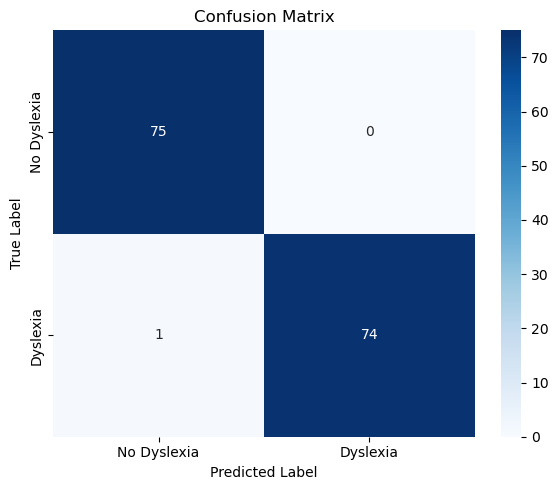


Additional Metrics for Test Results:
Sensitivity (Recall): 0.9867
Specificity: 1.0000
F1 Score: 0.9933

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       0.99      1.00      0.99        75
    Dyslexia       1.00      0.99      0.99        75

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

ROC AUC Score (Prob-based): 1.0000
PR AUC Score: 1.0000


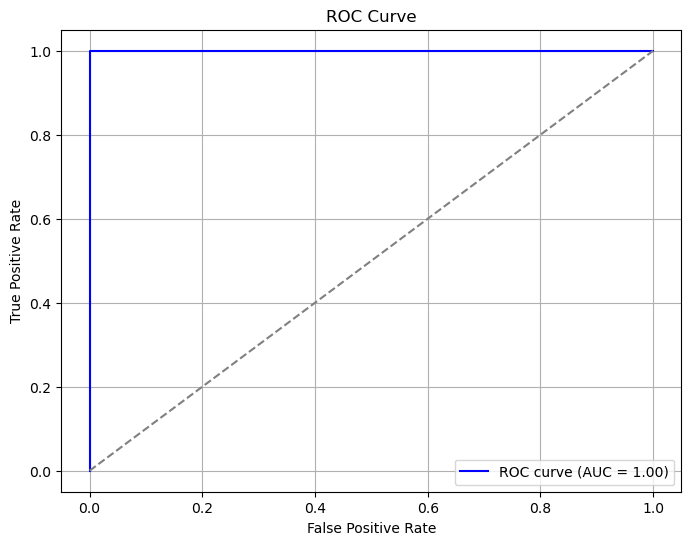

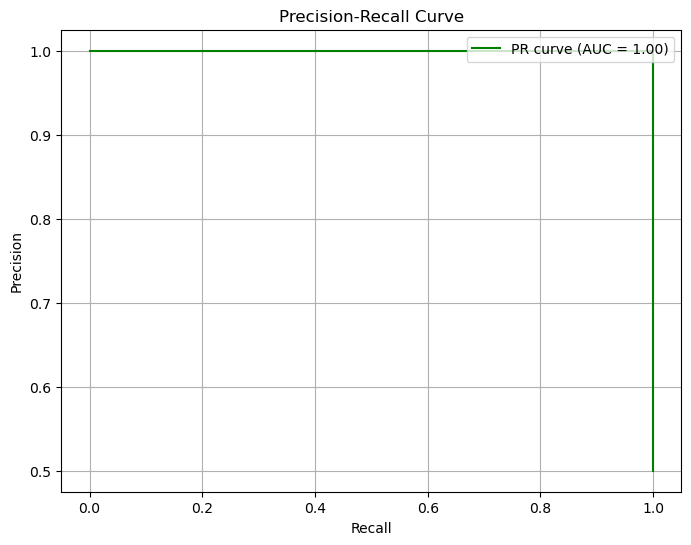

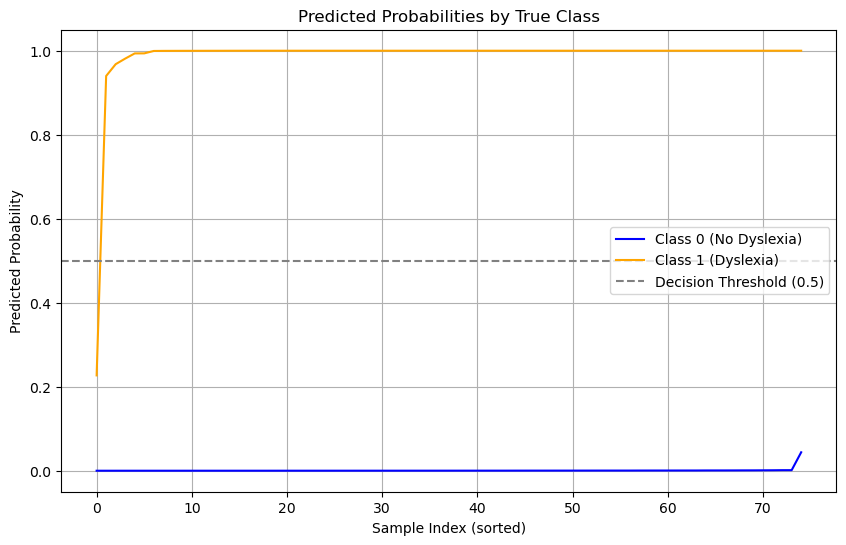


Model training and evaluation complete.


In [13]:
# Create MultiView model using both handwriting and transcript text 

# Ensure 'text' column is string type and handle potential NaN values
df['text'] = df['text'].fillna('').astype(str) # Fill NaN with empty string, then convert to str
print(f"Total samples: {len(df)}")

# --- Image Preprocessing (Pre-loading all images) ---
print("Loading and preprocessing all images...")
all_images = []
for index, row in df.iterrows():
    image_path = row['file_path']
    full_image_path = image_path 
    try:
        # Load image file
        img = tf.io.read_file(full_image_path)
        # Decode image
        img = tf.image.decode_jpeg(img, channels=3) 
        # Resize image
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        # Apply ResNet50 specific preprocessing
        img = tf.keras.applications.resnet50.preprocess_input(img)
        all_images.append(img)
    except Exception as e:
        print(f"Error loading image {full_image_path}: {e}. Appending black image placeholder.")
        all_images.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32))

all_images = np.array(all_images)
print(f"All images loaded. Shape: {all_images.shape}")

# --- Text Tokenization (Pre-tokenizing all text) ---
print("Loading BERT tokenizer and tokenizing all text...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

all_input_ids = []
all_attention_masks = []

for text_entry in df['text']:
    encoded_input = tokenizer(
        text_entry,  
        padding='max_length',
        truncation=True,
        max_length=128, # Consistent max length
        return_tensors='np'  
    )
    #   Access the first (and only) item in the batch dimension [0]
    all_input_ids.append(encoded_input['input_ids'][0])
    all_attention_masks.append(encoded_input['attention_mask'][0])

all_input_ids = np.array(all_input_ids)
all_attention_masks = np.array(all_attention_masks)
print(f"All text tokenized. Input IDs shape: {all_input_ids.shape}, Attention Masks shape: {all_attention_masks.shape}")

# Step Split into Training (70%) and Temporary (30%)
X_images_train, X_images_temp, \
X_input_ids_train, X_input_ids_temp, \
X_attention_masks_train, X_attention_masks_temp, \
y_train, y_temp = train_test_split(
    all_images,
    all_input_ids,
    all_attention_masks,
    df['presence_of_dyslexia'].values,
    test_size=0.3,  
    random_state=seed,
    stratify=df['presence_of_dyslexia'].values
)

# Split the Temporary set (30%) into Validation (15%) and Test (15%)
X_images_val, X_images_test, \
X_input_ids_val, X_input_ids_test, \
X_attention_masks_val, X_attention_masks_test, \
y_val, y_test = train_test_split(
    X_images_temp,
    X_input_ids_temp,
    X_attention_masks_temp,
    y_temp,
    test_size=0.5, 
    random_state=seed,
    stratify=y_temp # Stratify based on the labels of the temp set
)

print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")
print(f"Test samples: {len(y_val)}")

# --- Create TensorFlow Datasets from NumPy arrays ---
def create_tf_dataset_from_np(images, input_ids, attention_masks, labels, augment=False):
    """
    Creates a TensorFlow Dataset from NumPy arrays.
    Applies augmentation as a TensorFlow operation if specified.
    """
    ds = tf.data.Dataset.from_tensor_slices(
        (
            {'image_input': images, 'input_ids': input_ids, 'attention_mask': attention_masks},
            labels
        )
    )

    if augment:
        ds = ds.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = create_tf_dataset_from_np(X_images_train, X_input_ids_train, X_attention_masks_train, y_train, augment=False)
val_dataset = create_tf_dataset_from_np(X_images_val, X_input_ids_val, X_attention_masks_val, y_val, augment=False)
test_dataset = create_tf_dataset_from_np(X_images_test, X_input_ids_test, X_attention_masks_test, y_test, augment=False)


print("TensorFlow Datasets created from preprocessed NumPy arrays.")

# --- Custom Keras Layer for BERT Model ---
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True) 
        self.bert_model.trainable = False

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        # The training=False argument is crucial to prevent issues with symbolic tensors
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, training=False)
        # The [CLS] token output is typically at index 0 of the last_hidden_state
        return bert_output.last_hidden_state[:, 0, :]

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": "bert-base-cased"}) 
        return config

# --- Define the Multi-Modal Model ---
print("Building multi-modal model architecture...")

# Image Branch (ResNet50)
resnet_input = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_input')
resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=resnet_input
)

# Freeze ResNet50 layers
resnet_model.trainable = False
print("ResNet50 model loaded and layers frozen.")

# Extract features from ResNet50 output
image_features = resnet_model.output
image_features = layers.GlobalAveragePooling2D()(image_features)

# Text Branch (BERT) using the custom layer
bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor")
text_features = bert_embedding_extractor({'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask})
print("BERT model wrapped in custom layer and layers frozen.")

# Concatenate features from both modalities
concatenated_features = layers.Concatenate()([image_features, text_features])

# Classifier Head (New layers to be trained)
'''classifier_head = layers.Dense(256, activation='relu')(concatenated_features)
classifier_head = layers.Dropout(0.3)(classifier_head)
classifier_head = layers.Dense(128, activation='relu')(classifier_head)
classifier_head = layers.Dropout(0.3)(classifier_head)
output_layer = layers.Dense(1, activation='sigmoid', name='output')(classifier_head)'''
# Late fusion: combine the two modalities, decided 1024 from Seeland and Mader paper,
# (we have the feature vectors as 2048 (image) + 768 (text))
fusion = layers.Dense(1024, activation='relu')(concatenated_features)
fusion = layers.Dropout(0.5)(fusion)
# Final binary classification
output_layer = layers.Dense(1, activation='sigmoid', name='output')(fusion)

# Create the final multi-modal model
model = keras.Model(
    inputs={'image_input': resnet_input, 'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask},
    outputs=output_layer
)

# --- Compile and Train the Model ---
print("Compiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.summary()

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training model...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback]
)

# --- Evaluation ---
print("\nEvaluating model on Test set...")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions and classification report
all_preds = []
all_labels = []
# Create a dataset for prediction from validation data
predict_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {'image_input': X_images_test, 'input_ids': X_input_ids_test, 'attention_mask': X_attention_masks_test},
        y_test
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for inputs, labels in predict_dataset:
    predictions = model.predict(inputs)
    all_preds.extend(predictions.flatten().tolist())
    all_labels.extend(labels.numpy().flatten().tolist())

# Convert probabilities to binary predictions (0 or 1)
binary_preds = np.array(all_preds) > 0.5

print("\nClassification Report:")
print(classification_report(all_labels, binary_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, binary_preds))

# --- Show final performance metrics ---
show_performance_metrics(all_labels, all_preds)

print("\nModel training and evaluation complete.")


# 4 Existing MultiView model with added Noise Image View

Total samples: 1000
Loading and preprocessing all images...
All images loaded. Shape: (1000, 224, 224, 3)
Loading BERT tokenizer and tokenizing all text...


/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


All text tokenized. Input IDs shape: (1000, 128), Attention Masks shape: (1000, 128)
All noise images generated. Shape: (1000, 224, 224, 3)
Training samples: 700
Validation samples: 150
Test samples: 150
TensorFlow Datasets created from preprocessed NumPy arrays with noise view.
Building multi-modal model architecture with noise view...
ResNet50 model loaded and layers frozen.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

BERT model wrapped in custom layer and layers frozen.
Compiling model...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 52,158,209 (198.97 MB)

 Trainable params: 4,982,785 (19.01 MB)

 Non-trainable params: 47,175,424 (179.96 MB)

Training model...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 909ms/step - accuracy: 0.8218 - loss: 0.3526 - val_accuracy: 1.0000 - val_loss: 0.0257
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 860ms/step - accuracy: 0.9918 - loss: 0.0398 - val_accuracy: 1.0000 - val_loss: 0.0161
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 849ms/step - accuracy: 0.9941 - loss: 0.0231 - val_accuracy: 1.0000 - val_loss: 0.0121
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 859ms/step - accuracy: 0.9859 - loss: 0.0294 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 848ms/step - accuracy: 0.9993 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss: 0.0100
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 850ms/step - accuracy: 0.9983 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 848ms/step - accuracy: 0.9965 - loss: 0.0101 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 850ms/step - accuracy: 1.0000 - loss:

2025-08-22 18:37:37.965958: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


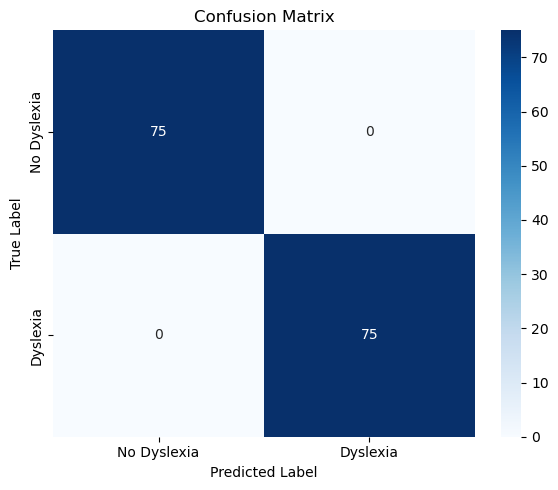


Additional Metrics for Test Results:
Sensitivity (Recall): 1.0000
Specificity: 1.0000
F1 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       1.00      1.00      1.00        75
    Dyslexia       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

ROC AUC Score (Prob-based): 1.0000
PR AUC Score: 1.0000


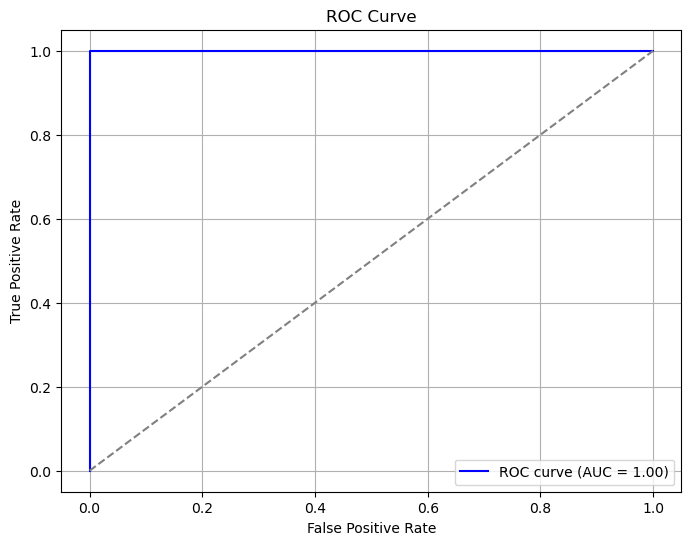

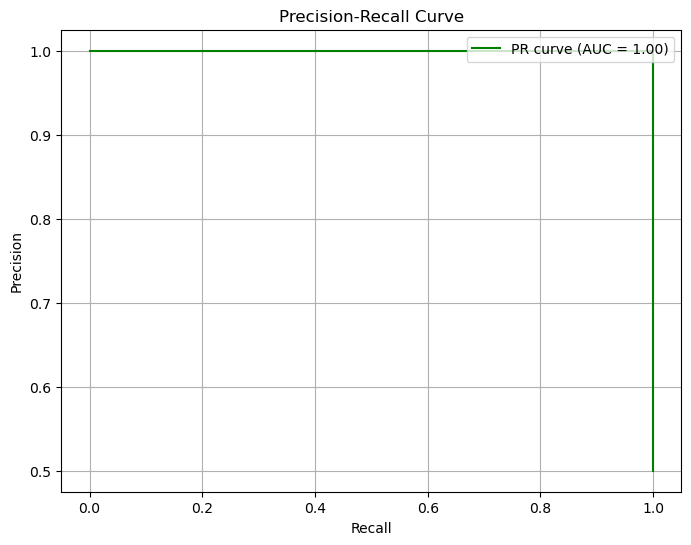

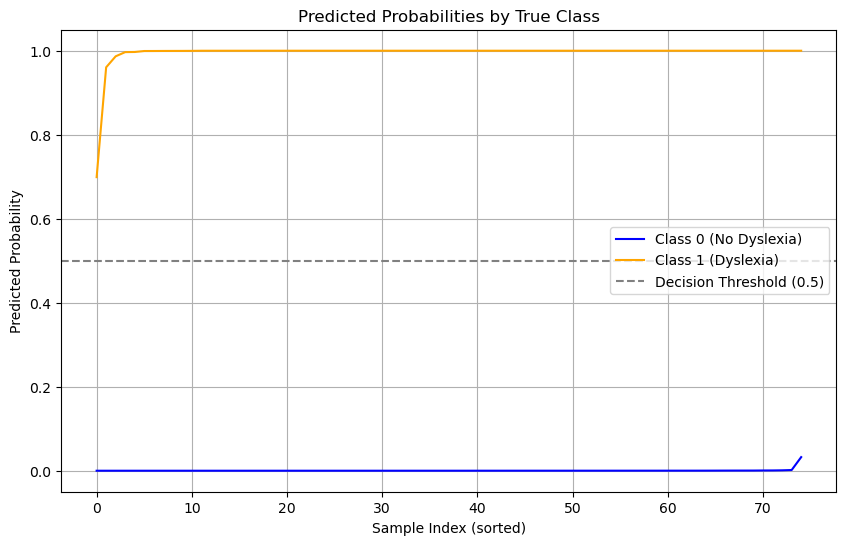


Model training and evaluation complete.


In [ ]:
# Noise Image dimensions 
NOISE_IMG_HEIGHT = 224
NOISE_IMG_WIDTH = 224
NOISE_IMG_CHANNELS = 3

# Ensure 'text' column is string type and handle potential NaN values
df['text'] = df['text'].fillna('').astype(str) # Fill NaN with empty string, then convert to str
print(f"Total samples: {len(df)}")

# --- Image Preprocessing (Pre-loading all images) ---
print("Loading and preprocessing all images...")
all_images = []
for index, row in df.iterrows():
    image_path = row['file_path']
    full_image_path = image_path
    
    # Check if the image path is valid before trying to open
    if not os.path.exists(full_image_path):
        print(f"Warning: Image file not found at {full_image_path}. Appending black image placeholder.")
        all_images.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32))
        continue # Skip

    try:
        # Load image file
        img = tf.io.read_file(full_image_path)
        # Decode image  
        img = tf.image.decode_jpeg(img, channels=3)  
        # Resize image
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        # Apply ResNet50 specific preprocessing
        img = tf.keras.applications.resnet50.preprocess_input(img)
        all_images.append(img)
    except Exception as e:
        print(f"Error loading image {full_image_path}: {e}. Appending black image placeholder.")
        all_images.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32))

all_images = np.array(all_images)
print(f"All images loaded. Shape: {all_images.shape}")

# --- Text Tokenization (Pre-tokenizing all text) ---
print("Loading BERT tokenizer and tokenizing all text...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

all_input_ids = []
all_attention_masks = []

for text_entry in df['text']:
    encoded_input = tokenizer(
        text_entry,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='np'
    )
    all_input_ids.append(encoded_input['input_ids'][0])
    all_attention_masks.append(encoded_input['attention_mask'][0])

all_input_ids = np.array(all_input_ids)
all_attention_masks = np.array(all_attention_masks)
print(f"All text tokenized. Input IDs shape: {all_input_ids.shape}, Attention Masks shape: {all_attention_masks.shape}")

# --- Generate Noise Data ---
# Generate random noise images for the entire dataset upfront
# Shape: (num_images, NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS)
# Values uniformly sampled from [0, 1) and then normalized later.
all_noise_images = np.random.rand(
    len(df), NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS
).astype(np.float32)
print(f"All noise images generated. Shape: {all_noise_images.shape}")


# Split into Training (70%) and Temporary (30%)
X_images_train, X_images_temp, \
X_input_ids_train, X_input_ids_temp, \
X_attention_masks_train, X_attention_masks_temp, \
X_noise_train, X_noise_temp, \
y_train, y_temp = train_test_split(
    all_images,
    all_input_ids,
    all_attention_masks,
    all_noise_images, # Add noise images to the split
    df['presence_of_dyslexia'].values,
    test_size=0.3,
    random_state=seed,
    stratify=df['presence_of_dyslexia'].values
)

#  Split the Temporary set (30%) into Validation (15%) and Test (15%)
X_images_val, X_images_test, \
X_input_ids_val, X_input_ids_test, \
X_attention_masks_val, X_attention_masks_test, \
X_noise_val, X_noise_test, \
y_val, y_test = train_test_split(
    X_images_temp,
    X_input_ids_temp,
    X_attention_masks_temp,
    X_noise_temp, # Add noise images to the split
    y_temp,
    test_size=0.5,
    random_state=seed,
    stratify=y_temp
)

print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")
print(f"Test samples: {len(y_test)}")


# --- Create TensorFlow Datasets from NumPy arrays ---
def create_tf_dataset_from_np(images, input_ids, attention_masks, noise_images, labels, augment=False):
    """
    Creates a TensorFlow Dataset from NumPy arrays.
    Includes an image normalization function for both real and noise images.
    """

    ds = tf.data.Dataset.from_tensor_slices(
        (
            {
                'image_input': images,
                'input_ids': input_ids,
                'attention_mask': attention_masks,
                'noise_input': noise_images # Add noise input here
            },
            labels
        )
    )

    def apply_transformations(inputs, label):
        # Apply normalization to the real and noise image
        inputs['noise_input'] =  tf.keras.applications.resnet50.preprocess_input(inputs['noise_input']*255)

        # Have added this in but have not decided to use this as the dataset is not very small but can be used in 
        # future work
        if augment:
            img = inputs['image_input']
            # Apply random augmentation for training images using TF ops
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.2)
            img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
            inputs['image_input'] = img
            
        return inputs, label

    # Map the transformations function over the dataset
    ds = ds.map(apply_transformations, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = create_tf_dataset_from_np(X_images_train, X_input_ids_train, X_attention_masks_train, X_noise_train, y_train, augment=False)
val_dataset = create_tf_dataset_from_np(X_images_val, X_input_ids_val, X_attention_masks_val, X_noise_val, y_val, augment=False)
test_dataset = create_tf_dataset_from_np(X_images_test, X_input_ids_test, X_attention_masks_test, X_noise_test, y_test, augment=False)
print("TensorFlow Datasets created from preprocessed NumPy arrays with noise view.")

# --- Custom Keras Layer for BERT Model ---
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True)
        self.bert_model.trainable = False

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, training=False)
        return bert_output.last_hidden_state[:, 0, :]

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": "bert-base-cased"}) 
        return config

# --- Define the Multi-Modal Model with Noise View ---
print("Building multi-modal model architecture with noise view...")

# Image Branch (ResNet50)
resnet_input = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_input')
resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=resnet_input
)

# Freeze ResNet50 layers
resnet_model.trainable = False
print("ResNet50 model loaded and layers frozen.")

# Extract features from ResNet50 output
image_features = resnet_model.output
image_features = layers.GlobalAveragePooling2D()(image_features)

# Text Branch (BERT) using the custom layer
bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# Ensure this matches the tokenizer model name used earlier
bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor")
text_features = bert_embedding_extractor({'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask})
print("BERT model wrapped in custom layer and layers frozen.")

# --- Noise Branch (Using ResNet50 with ImageNet weights) ---
noise_input = keras.Input(shape=(NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS), name='noise_input')

# Create a new ResNet50 instance for the noise branch
# Use 'name' and 'layer_name_prefix' to ensure unique layer names
# Load ResNet50 base (without including the input_tensor here)
base_noise_resnet = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS)
)

# Rename all layers in the noise ResNet to avoid name collisions
for layer in base_noise_resnet.layers:
    layer._name = f"noise_{layer.name}"

# Freeze noise ResNet50 layers
base_noise_resnet.trainable = False

# Apply it to the noise input manually
noise_features = base_noise_resnet(noise_input)
noise_features = layers.GlobalAveragePooling2D()(noise_features)

# Concatenate features from all three modalities
concatenated_features = layers.Concatenate()([image_features, text_features, noise_features])

# Classifier Head (New layers to be trained)
# Late fusion: combine the three modalities, decided 1024 from Seeland and Mader,(we have the feature vectors as 2048 (image) + 768 (text) + 2048 (image))
fusion = layers.Dense(1024, activation='relu')(concatenated_features)
fusion = layers.Dropout(0.5)(fusion)
# Final binary classification
output_layer = layers.Dense(1, activation='sigmoid', name='output')(fusion)

# Create the final multi-modal model
model = keras.Model(
    inputs={
        'image_input': resnet_input,
        'input_ids': bert_input_ids,
        'attention_mask': bert_attention_mask,
        'noise_input': noise_input # Add noise input to the model inputs
    },
    outputs=output_layer
)

# --- Compile and Train the Model ---
print("Compiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.summary()

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training model...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback]
)

# --- Evaluation ---
print("\nEvaluating model on Test set...")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions and classification report
all_preds = []
all_labels = []
# Create a dataset for prediction from test data
predict_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            'image_input': X_images_test,
            'input_ids': X_input_ids_test,
            'attention_mask': X_attention_masks_test,
            'noise_input': X_noise_test # Include noise input for prediction
        },
        y_test
    )
)

# Apply the same normalization to the prediction dataset
def apply_prediction_transformations(inputs, label):
    inputs['noise_input'] = tf.cast(inputs['noise_input'], tf.float32)
    # Apply ResNet50 preprocessing
    inputs['noise_input'] = tf.keras.applications.resnet50.preprocess_input(inputs['noise_input']*255)
    return inputs, label

predict_dataset = predict_dataset.map(apply_prediction_transformations, num_parallel_calls=tf.data.AUTOTUNE)
predict_dataset = predict_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


for inputs, labels in predict_dataset:
    predictions = model.predict(inputs)
    all_preds.extend(predictions.flatten().tolist())
    all_labels.extend(labels.numpy().flatten().tolist())

# Convert probabilities to binary predictions (0 or 1)
binary_preds = np.array(all_preds) > 0.5

print("\nClassification Report:")
print(classification_report(all_labels, binary_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, binary_preds))

# --- Show final performance metrics ---
show_performance_metrics(all_labels, all_preds)
print("\nModel training and evaluation complete.")

# 5 MultiView model with our two original views and a noisy view 
Adding MNIST-style letter images as a structured noise view instead of purely random noise adds a new modality and a controlled noise ratio, which could simulate misleading or adversarial data during multi-view learning.

In [ ]:
# Load MNIST data
(x_train_mnist, y_train_mnist), _ = mnist.load_data()

# Filter for digits 0 and 1 only
digit_images = {
    0: x_train_mnist[y_train_mnist == 0],
    1: x_train_mnist[y_train_mnist == 1]
}

def create_mnist_digit_noise(labels, noise_ratio=0.3):
    """
    For each label (0 or 1):
    - With `noise_ratio` probability, use a digit image from the *wrong class*
    - Otherwise, use the correct digit image
    - Labels are always kept correct
    """
    structured_noise = []

    for i, label in enumerate(labels):
        correct_digit = label          # 0 or 1
        wrong_digit = 1 - correct_digit

        # Decide whether to use the correct or wrong digit image
        use_wrong_image = np.random.rand() < noise_ratio
        chosen_digit = wrong_digit if use_wrong_image else correct_digit

        # Pick one digit image
        raw_img = random.choice(digit_images[chosen_digit])

        # Convert 28x28 grayscale to 224x224 RGB
        img_pil = Image.fromarray(raw_img).convert('RGB')
        img_pil = img_pil.resize((NOISE_IMG_WIDTH, NOISE_IMG_HEIGHT))
        img_arr = np.array(img_pil).astype(np.float32)

        # Preprocess for ResNet50
        img_arr = tf.keras.applications.resnet50.preprocess_input(img_arr)

        structured_noise.append(img_arr)

    return np.array(structured_noise, dtype=np.float32)

# This function trains a ResNet50 classifier directly on the label-noise MNist images alone 
# (with no text or real image input), to see if these images can predict the dyslexia label 
# on their own, which is in effect the number of the handwritten image.
def testMNistImages(df, noise_ratio=0.3):
    """
    Train a ResNet50 classifier solely on noisy MNIST digit images generated from labels.
    Noise ratio controls how often the digit is flipped (label noise).
    """
    y = df['presence_of_dyslexia'].values.astype(np.float32)

    # Split labels first
    y_train, y_temp = train_test_split(y, test_size=0.3, random_state=seed, stratify=y)
    y_val, y_test = train_test_split(y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

    # Generate noisy MNIST images for each split, applying noise ratio only to train set
    X_train = create_mnist_digit_noise(y_train, noise_ratio=noise_ratio)
    X_val   = create_mnist_digit_noise(y_val, noise_ratio=noise_ratio)   
    X_test  = create_mnist_digit_noise(y_test, noise_ratio=noise_ratio)   

    # Build model
    resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    resnet_base.trainable = False

    inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = resnet_base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=output)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop]
    )

    loss, acc = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

    all_preds = model.predict(X_test).flatten()
    show_performance_metrics(y_test, all_preds)


Total samples: 1000
Loading and preprocessing all images...
All images loaded. Shape: (1000, 224, 224, 3)
Loading BERT tokenizer and tokenizing all text...


/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


All text tokenized. Input IDs shape: (1000, 128), Attention Masks shape: (1000, 128)
Generating MNIST-digit-based structured noise (0 vs 1)...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.5449 - loss: 0.7366 - val_accuracy: 0.5800 - val_loss: 0.6862
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.6431 - loss: 0.6337 - val_accuracy: 0.6267 - val_loss: 0.6772
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.6993 - loss: 0.6049 - val_accuracy: 0.6400 - val_loss: 0.6732
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.6931 - loss: 0.6196 - val_accuracy: 0.6533 - val_loss: 0.6704
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.6944 - loss: 0.6046 - val_accuracy: 0.6600 - val_loss: 0.6716
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.7053 - loss: 0.6080 - val_accuracy: 0.6667 - val_loss: 0.6709
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.7081 - loss: 0.5978 - 

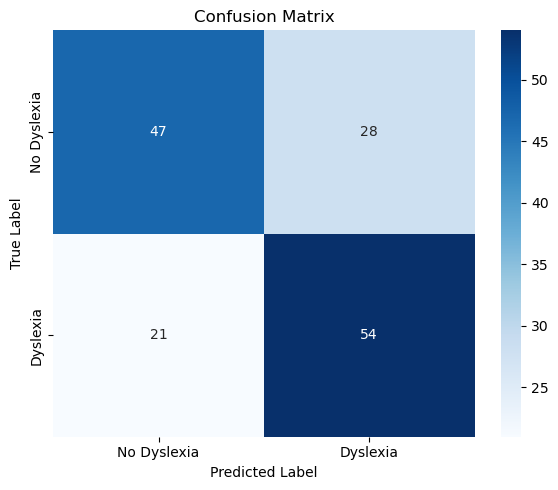


Additional Metrics for Test Results:
Sensitivity (Recall): 0.7200
Specificity: 0.6267
F1 Score: 0.6879

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       0.69      0.63      0.66        75
    Dyslexia       0.66      0.72      0.69        75

    accuracy                           0.67       150
   macro avg       0.67      0.67      0.67       150
weighted avg       0.67      0.67      0.67       150

ROC AUC Score (Prob-based): 0.7024
PR AUC Score: 0.6919


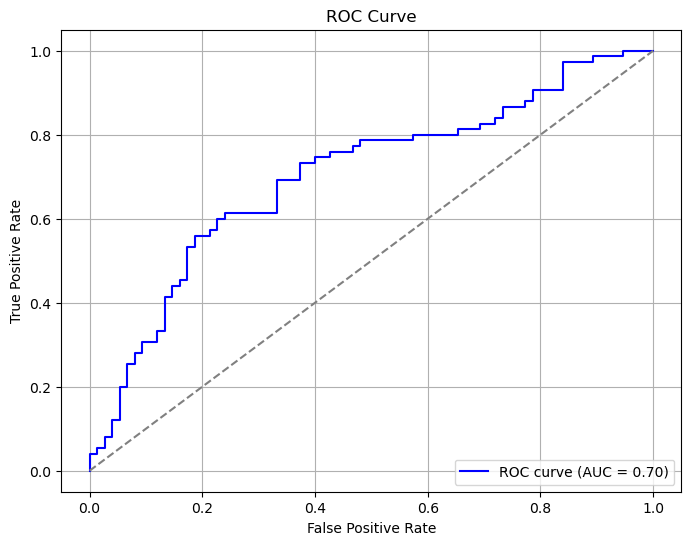

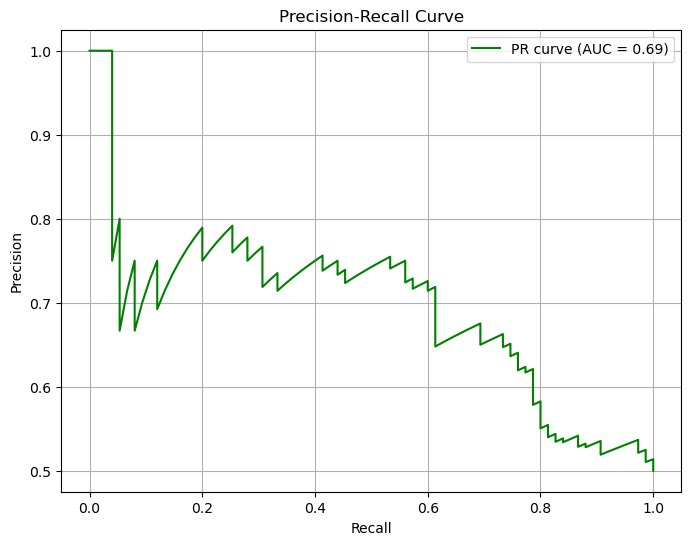

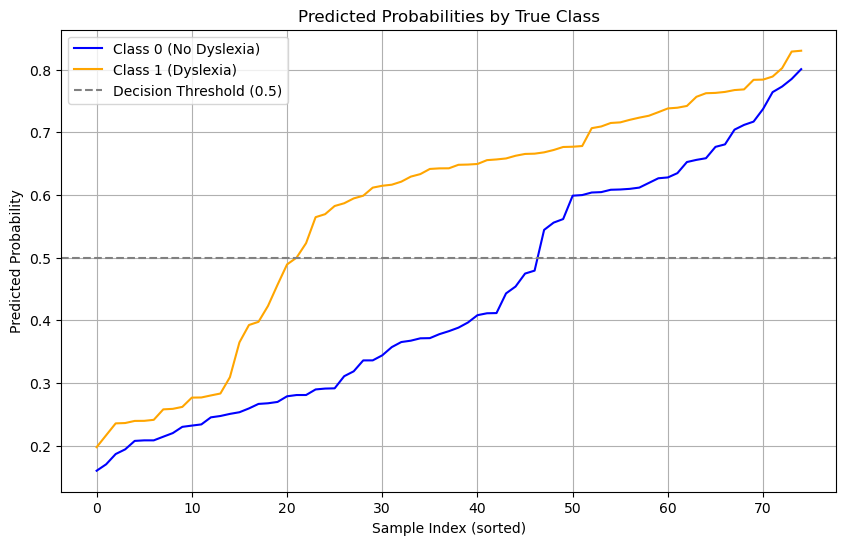

Training samples: 700
Validation samples: 150
Test samples: 150
TensorFlow Datasets created from preprocessed NumPy arrays with noise view.
Building multi-modal model architecture with noise view...
ResNet50 model loaded and layers frozen.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

BERT model wrapped in custom layer and layers frozen.
Compiling model...


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 52,158,209 (198.97 MB)

 Trainable params: 4,982,785 (19.01 MB)

 Non-trainable params: 47,175,424 (179.96 MB)

Training model...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 933ms/step - accuracy: 0.8292 - loss: 0.3484 - val_accuracy: 0.9867 - val_loss: 0.0259
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 879ms/step - accuracy: 0.9885 - loss: 0.0421 - val_accuracy: 1.0000 - val_loss: 0.0118
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 880ms/step - accuracy: 0.9947 - loss: 0.0213 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 877ms/step - accuracy: 0.9990 - loss: 0.0160 - val_accuracy: 1.0000 - val_loss: 0.0116
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 876ms/step - accuracy: 0.9848 - loss: 0.0299 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 876ms/step - accuracy: 0.9946 - loss: 0.0216 - val_accuracy: 0.9933 - val_loss: 0.0127
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 877ms/step - accuracy: 0.9973 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 859ms/step - accuracy: 0.9902 - loss:

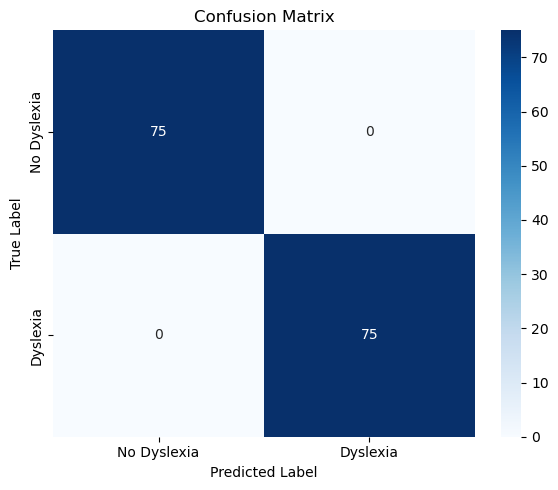


Additional Metrics for Test Results:
Sensitivity (Recall): 1.0000
Specificity: 1.0000
F1 Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       1.00      1.00      1.00        75
    Dyslexia       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

ROC AUC Score (Prob-based): 1.0000
PR AUC Score: 1.0000


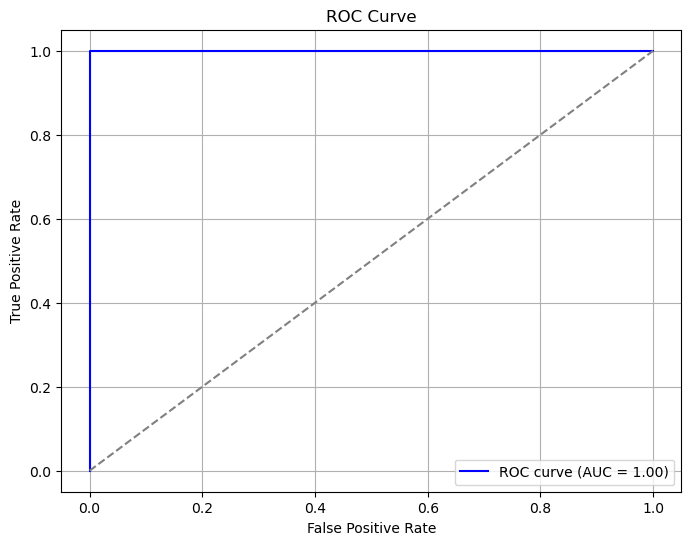

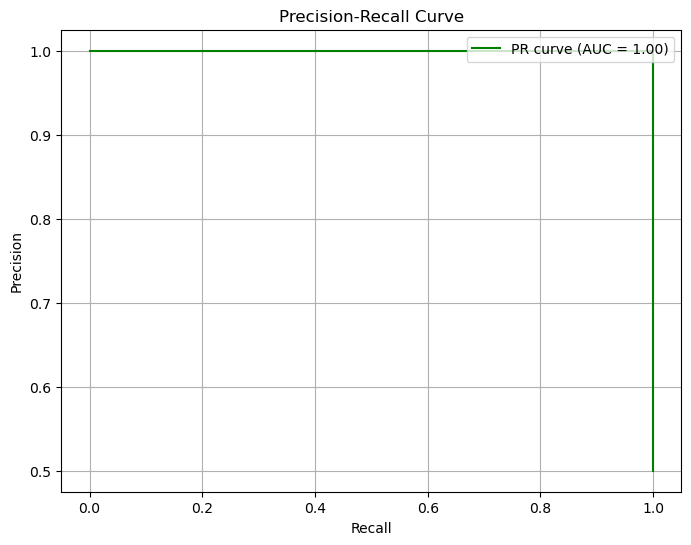

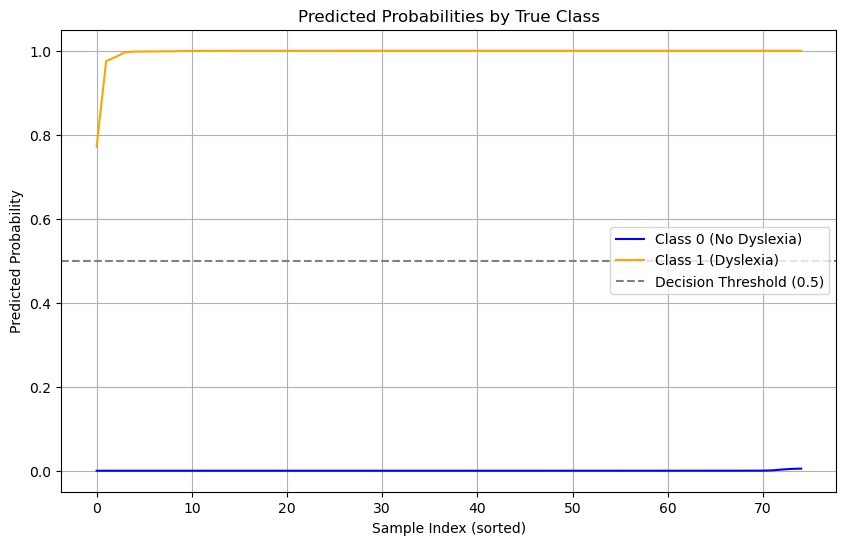


Model training and evaluation complete.


In [ ]:
# Ensure 'text' column is string type and handle potential NaN values
df['text'] = df['text'].fillna('').astype(str) # Fill NaN with empty string, then convert to str
print(f"Total samples: {len(df)}")

# --- Image Preprocessing (Pre-loading all images) ---
print("Loading and preprocessing all images...")
all_images = []
for index, row in df.iterrows():
    image_path = row['file_path']
    full_image_path = image_path
    
    # Check if the image path is valid before trying to open
    if not os.path.exists(full_image_path):
        print(f"Warning: Image file not found at {full_image_path}. Appending black image placeholder.")
        all_images.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32))
        continue # Skip

    try:
        # Load image file
        img = tf.io.read_file(full_image_path)
        # Decode image 
        img = tf.image.decode_jpeg(img, channels=3)  
        # Resize image
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        # Apply ResNet50 specific preprocessing
        img = tf.keras.applications.resnet50.preprocess_input(img)
        
        all_images.append(img)
    except Exception as e:
        print(f"Error loading image {full_image_path}: {e}. Appending black image placeholder.")
        all_images.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32))

all_images = np.array(all_images)
print(f"All images loaded. Shape: {all_images.shape}")

# --- Text Tokenization (Pre-tokenizing all text) ---
print("Loading BERT tokenizer and tokenizing all text...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

all_input_ids = []
all_attention_masks = []

for text_entry in df['text']:
    encoded_input = tokenizer(
        text_entry,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='np'
    )
    all_input_ids.append(encoded_input['input_ids'][0])
    all_attention_masks.append(encoded_input['attention_mask'][0])

all_input_ids = np.array(all_input_ids)
all_attention_masks = np.array(all_attention_masks)
print(f"All text tokenized. Input IDs shape: {all_input_ids.shape}, Attention Masks shape: {all_attention_masks.shape}")

# --- Generate Noisy MNIST Data ---
print("Generating MNIST-digit-based structured noise (0 vs 1)...")
#all_noise_images = create_mnist_digit_noise(df['presence_of_dyslexia'].values, noise_ratio=0.3)
#print(f"Structured noise images created: {all_noise_images.shape}")
#print(f"All noise images generated. Shape: {all_noise_images.shape}")

testMNistImages( df, noise_ratio=0.3)

#  Split into train (70%) and temp (30%)
train_idx, temp_idx, y_train, y_temp = train_test_split(
    np.arange(len(df['presence_of_dyslexia'].values)),
    df['presence_of_dyslexia'].values,
    test_size=0.3,
    stratify=df['presence_of_dyslexia'].values,
    random_state=seed
)

#  Split temp into val (15%) and test (15%)
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=seed
)

# Slice real image data
X_images_train = all_images[train_idx]
X_images_val   = all_images[val_idx]
X_images_test  = all_images[test_idx]

# Slice tokenized BERT inputs
X_input_ids_train = all_input_ids[train_idx]
X_input_ids_val   = all_input_ids[val_idx]
X_input_ids_test  = all_input_ids[test_idx]

X_attention_masks_train = all_attention_masks[train_idx]
X_attention_masks_val   = all_attention_masks[val_idx]
X_attention_masks_test  = all_attention_masks[test_idx]

# Now generate noise images per split with custom noise ratio
X_noise_train = create_mnist_digit_noise(y_train, noise_ratio=0.3)
X_noise_val   = create_mnist_digit_noise(y_val, noise_ratio=0.3)
X_noise_test  = create_mnist_digit_noise(y_test, noise_ratio=0.3)

print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")
print(f"Test samples: {len(y_test)}")

# --- Create TensorFlow Datasets from NumPy arrays ---
def create_tf_dataset_from_np(images, input_ids, attention_masks, noise_images, labels, augment=False, shuffle=False):
    """
    Creates a TensorFlow Dataset from NumPy arrays.
    Includes an image normalization function for both real and noise images.
    """
    ds = tf.data.Dataset.from_tensor_slices(
        (
            {
                'image_input': images,
                'input_ids': input_ids,
                'attention_mask': attention_masks,
                'noise_input': noise_images # Add noise input here
            },
            labels
        )
    )

    def apply_transformations(inputs, label):
       
        if augment:
            img = inputs['image_input']
            # Apply random augmentation for training images using TF ops
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.2)
            img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
            inputs['image_input'] = img
            
        return inputs, label
    if shuffle:
        ds = ds.shuffle(buffer_size=len(labels), reshuffle_each_iteration=True)

    # Map the transformations function over the dataset
    ds = ds.map(apply_transformations, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = create_tf_dataset_from_np(X_images_train, X_input_ids_train, X_attention_masks_train, X_noise_train, y_train, augment=False, shuffle=True)
val_dataset = create_tf_dataset_from_np(X_images_val, X_input_ids_val, X_attention_masks_val, X_noise_val, y_val, augment=False)
test_dataset = create_tf_dataset_from_np(X_images_test, X_input_ids_test, X_attention_masks_test, X_noise_test, y_test, augment=False)

print("TensorFlow Datasets created from preprocessed NumPy arrays with noise view.")

# --- Custom Keras Layer for BERT Model ---
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True)
        self.bert_model.trainable = False

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, training=False)
        return bert_output.last_hidden_state[:, 0, :]

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": "bert-base-cased"}) # Use the actual model name used for loading
        return config

# --- Define the Multi-Modal Model with Noise View ---
print("Building multi-modal model architecture with noise view...")

# Image Branch (ResNet50)
resnet_input = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_input')
resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=resnet_input
)

# Freeze ResNet50 layers
resnet_model.trainable = False
print("ResNet50 model loaded and layers frozen.")

# Extract features from ResNet50 output
image_features = resnet_model.output
image_features = layers.GlobalAveragePooling2D()(image_features)

# Text Branch (BERT) using the custom layer
bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor")
text_features = bert_embedding_extractor({'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask})
print("BERT model wrapped in custom layer and layers frozen.")

# --- Noise Branch (Using ResNet50 with ImageNet weights) ---
noise_input = keras.Input(shape=(NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS), name='noise_input')

# Create a new ResNet50 instance for the noise branch
# Load ResNet50 base (without including the input_tensor here)
base_noise_resnet = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS)
)

# Rename all layers in the noise ResNet to avoid name collisions
for layer in base_noise_resnet.layers:
    layer._name = f"noise_{layer.name}"

# Freeze noise ResNet50 layers
base_noise_resnet.trainable = False

# Apply it to the noise input manually
noise_features = base_noise_resnet(noise_input)
noise_features = layers.GlobalAveragePooling2D()(noise_features)

# Concatenate features from all three modalities
concatenated_features = layers.Concatenate()([image_features, text_features, noise_features])

# Classifier Head (New layers to be trained)
'''classifier_head = layers.Dense(256, activation='relu')(concatenated_features)
classifier_head = layers.Dropout(0.3)(classifier_head)
classifier_head = layers.Dense(128, activation='relu')(classifier_head)
classifier_head = layers.Dropout(0.3)(classifier_head)
output_layer = layers.Dense(1, activation='sigmoid', name='output')(classifier_head)'''

# Late fusion: combine the three modalities, decided on 1024,( we have the feature vectors 
# as 2048 (image) + 768 (text) + 2048 (image))
fusion = layers.Dense(1024, activation='relu')(concatenated_features)
fusion = layers.Dropout(0.5)(fusion)
# Final binary classification
output_layer = layers.Dense(1, activation='sigmoid', name='output')(fusion)

# Create the final multi-modal model
model = keras.Model(
    inputs={
        'image_input': resnet_input,
        'input_ids': bert_input_ids,
        'attention_mask': bert_attention_mask,
        'noise_input': noise_input # Add noise input to the model inputs
    },
    outputs=output_layer
)

# --- Compile and Train the Model ---
print("Compiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.summary()

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training model...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback]
)

# --- Evaluation ---
print("\nEvaluating model on Test set...")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

all_preds = []
all_labels = []

for inputs, labels in test_dataset:
    predictions = model.predict(inputs)
    all_preds.extend(predictions.flatten().tolist())
    all_labels.extend(labels.numpy().flatten().tolist())

# Generate predictions and classification report
show_performance_metrics(all_labels, all_preds)

print("\nModel training and evaluation complete.")

# 6 Extend MultiView model with our two original views and a noisy view 
Adding MNIST-style letter images as a structured noise view instead of purely random noise adds a new modality and a controlled noise ratio, which could simulate misleading or adversarial data during multi-view learning.
Test with varying noise levels of 5%, 10%, 15%, 20%

In [ ]:
digit_images = {
    0: x_train_mnist[y_train_mnist == 0],
    1: x_train_mnist[y_train_mnist == 1]
}

def build_multimodal_model(img_height, img_width, img_channels, noise_height, noise_width, noise_channels, image_input, image_features, input_ids,attention_mask, text_features):

    # --- Noise Branch (Using ResNet50 with ImageNet weights) ---
    noise_input = keras.Input(shape=(NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS), name='noise_input')

    # Create a new ResNet50 instance for the noise branch
    # Load ResNet50 base (without including the input_tensor here)
    base_noise_resnet = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS)
    )

    # Rename all layers in the noise ResNet to avoid name collisions
    for layer in base_noise_resnet.layers:
        layer._name = f"noise_{layer.name}"

    # Freeze noise ResNet50 layers
    base_noise_resnet.trainable = False

    # Apply it to the noise input manually
    noise_features = base_noise_resnet(noise_input)
    noise_features = layers.GlobalAveragePooling2D()(noise_features)

    # --- Concatenate Modalities ---
    concatenated = layers.Concatenate()([image_features, text_features, noise_features])

    # --- Fusion and Classifier Head ---
    # Late fusion: combine the three modalities, decided 2048 , as we have the feature vectors as 2048 (image) + 768 (text) + 2048 (image)
    fusion = layers.Dense(1024, activation='relu')(concatenated)
    fusion = layers.Dropout(0.5)(fusion)
    # Final binary classification
    output_layer = layers.Dense(1, activation='sigmoid', name='output')(fusion)

    # --- Full Model ---
    model = Model(
        inputs={
            'image_input': image_input,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'noise_input': noise_input
        },
        outputs=output_layer
    )

    return model
    
def run_experiment_with_noise_ratio(noise_ratio, df, 
                                     IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS,
                                     tokenizer, BATCH_SIZE=16, EPOCHS=30):
    print(f"\n===== Running experiment with noise_ratio = {noise_ratio} =====")

    # --- Split indices ---
    y = df['presence_of_dyslexia'].values
    train_idx, temp_idx, y_train, y_temp = train_test_split(
        np.arange(len(y)), y, test_size=0.3, stratify=y, random_state=seed)
    
    val_idx, test_idx, y_val, y_test = train_test_split(
        temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=seed)

    # --- Slice inputs ---
    X_images_train = all_images[train_idx]
    X_images_val   = all_images[val_idx]
    X_images_test  = all_images[test_idx]

    X_input_ids_train = all_input_ids[train_idx]
    X_input_ids_val   = all_input_ids[val_idx]
    X_input_ids_test  = all_input_ids[test_idx]

    X_attention_masks_train = all_attention_masks[train_idx]
    X_attention_masks_val   = all_attention_masks[val_idx]
    X_attention_masks_test  = all_attention_masks[test_idx]

    # --- Create structured noise separately for each set ---
    X_noise_train = create_mnist_digit_noise(y_train, noise_ratio=noise_ratio)
    X_noise_val   = create_mnist_digit_noise(y_val, noise_ratio=noise_ratio)
    X_noise_test  = create_mnist_digit_noise(y_test, noise_ratio=noise_ratio)

    # Create TF Datasets
    train_dataset = create_tf_dataset_from_np(X_images_train, X_input_ids_train, X_attention_masks_train, X_noise_train, y_train, augment=False, shuffle=True)
    val_dataset = create_tf_dataset_from_np(X_images_val, X_input_ids_val, X_attention_masks_val, X_noise_val, y_val, augment=False)
    test_dataset = create_tf_dataset_from_np(X_images_test, X_input_ids_test, X_attention_masks_test, X_noise_test, y_test, augment=False)

    # --- Image Branch (ResNet50) ---
    image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_input')
    resnet_base = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=image_input
    )
    resnet_base.trainable = False  # freeze ResNet
    image_features = layers.GlobalAveragePooling2D()(resnet_base.output)

   # Define inputs
    bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    # BERT embedding extraction
    bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor")
    text_features = bert_embedding_extractor({
    'input_ids': bert_input_ids,
    'attention_mask': bert_attention_mask
    })

    # Rebuild and compile model
    model = build_multimodal_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NOISE_IMG_HEIGHT, NOISE_IMG_WIDTH, NOISE_IMG_CHANNELS, image_input=image_input, 
    image_features=image_features, input_ids=bert_input_ids,attention_mask=bert_attention_mask, text_features=text_features)  # Wrap  model construction into a function
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    # Train
    history = model.fit(train_dataset,
                        epochs=EPOCHS,
                        validation_data=val_dataset,
                        callbacks=[early_stopping],
                        verbose=0)  # silent training for batch runs

    # Evaluate
    test_loss, test_acc = model.evaluate(test_dataset, verbose=0)

    # Predictions for classification report
    preds, true_labels = [], []
    for batch_inputs, batch_labels in test_dataset:
        batch_preds = model.predict(batch_inputs, verbose=0).flatten()
        preds.extend(batch_preds)
        true_labels.extend(batch_labels.numpy())

    binary_preds = np.array(preds) > 0.5
    report = classification_report(true_labels, binary_preds, output_dict=True)

    true_labels_np = np.array(true_labels)

    # Confusion matrix: [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(true_labels_np, binary_preds).ravel()

    # Specificity: TN / (TN + FP)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Sensitivity (Recall): already in report['1']['recall'], but recalculate for clarity
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # AUC-ROC
    auc_roc = roc_auc_score(true_labels_np, preds)

    return {
        'noise_ratio': noise_ratio,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'precision': report['1']['precision'], # also called sensitivity which 
        'recall': report['1']['recall'],
        'f1': report['1']['f1-score'],
        
    'specificity': specificity,
    'f1': report['1']['f1-score'],
    'auc_roc': auc_roc
    }

results = []
noise_ratios = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

for ratio in noise_ratios:
    result = run_experiment_with_noise_ratio(
        noise_ratio=ratio,
        df=df,
        IMG_HEIGHT=IMG_HEIGHT,
        IMG_WIDTH=IMG_WIDTH,
        IMG_CHANNELS=IMG_CHANNELS,
        tokenizer=tokenizer,
        BATCH_SIZE=16,
        EPOCHS=30
    )
    results.append(result)

    print(f"Done with noise_ratio={ratio}: Accuracy={result['test_accuracy']:.4f}, F1={result['f1']:.4f}, AUC={result['auc_roc']:.4f}, Sens={result['recall']:.4f}, Spec={result['specificity']:.4f}")

results_df = pd.DataFrame(results)
print("\n=== Summary of Results ===")
print(results_df)

#  plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['noise_ratio'], results_df['test_accuracy'], marker='o', label='Test Accuracy')
plt.plot(results_df['noise_ratio'], results_df['f1'], marker='s', label='F1 Score')
plt.xlabel("Noise Ratio")
plt.ylabel("Performance")
plt.ylim(0.9, 1.0)  
plt.title("Performance vs. Noise Ratio in MNIST Digit View")
plt.legend()
plt.grid(True)
plt.show()


===== Running experiment with noise_ratio = 0.05 =====


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Done with noise_ratio=0.05: Accuracy=1.0000, F1=1.0000, AUC=1.0000, Sens=1.0000, Spec=1.0000

===== Running experiment with noise_ratio = 0.1 =====


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Done with noise_ratio=0.1: Accuracy=1.0000, F1=1.0000, AUC=1.0000, Sens=1.0000, Spec=1.0000

===== Running experiment with noise_ratio = 0.15 =====


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already